In [29]:
import os
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from sklearn.externals import joblib
%matplotlib inline
import seaborn as sns

DIR = '/mnt/ml-team/minerva/open-solutions/home-credit'
description = pd.read_csv(os.path.join(DIR,'data/HomeCredit_columns_description.csv'),encoding = 'latin1')
application = pd.read_csv(os.path.join(DIR, 'files/unzipped_data/application_train.csv'))
bureau = pd.read_csv(os.path.join(DIR, 'files/unzipped_data/bureau.csv'), nrows=10000)

In [30]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


# Preprocessing
## Solution 3

In [31]:
(bureau['AMT_CREDIT_SUM'] == 0).sum()

409

This shows that imputing with nan with 0 is probably a bad idea

# Feature Engineering
## Solution 3
### Hand crafted features

In [32]:
bureau[bureau['SK_ID_CURR']==215354]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.00,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.00,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN
5,215354,5714467,Active,currency 1,-273,0,27460.0,NaN,0.0,0,180000.0,71017.38,108982.62,0.0,Credit card,-31,NaN
6,215354,5714468,Active,currency 1,-43,0,79.0,NaN,0.0,0,42103.8,42103.80,0.00,0.0,Consumer credit,-22,NaN


### First build helper columns

In [62]:
bureau['bureau_credit_active_binary'] = (bureau['CREDIT_ACTIVE'] != 'Closed').astype(int)
bureau['bureau_credit_enddate_binary'] = (bureau['DAYS_CREDIT_ENDDATE'] > 0).astype(int)

groupby_SK_ID_CURR = bureau.groupby(by=['SK_ID_CURR'])

In [63]:
description[description['Row'] == 'DAYS_CREDIT'].Description.tolist()

['How many days before current application did client apply for Credit Bureau credit']

In [64]:
features = pd.DataFrame({'SK_ID_CURR':bureau['SK_ID_CURR'].unique()})
features.head()

,SK_ID_CURR
0,215354
1,162297
2,402440
3,238881
4,222183


In [65]:
group_object = groupby_SK_ID_CURR['DAYS_CREDIT'].agg('count').reset_index()
group_object.rename(index=str, columns={'DAYS_CREDIT': 'bureau_number_of_past_loans'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,bureau_number_of_past_loans
0,215354,7
1,162297,6
2,402440,1
3,238881,7
4,222183,6


In [66]:
group_object = groupby_SK_ID_CURR['CREDIT_TYPE'].agg('nunique').reset_index()
group_object.rename(index=str, columns={'CREDIT_TYPE': 'bureau_number_of_loan_types'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types
0,215354,7,2
1,162297,6,3
2,402440,1,1
3,238881,7,2
4,222183,6,3


In [67]:
features['bureau_average_of_past_loans_per_type'] = \
    features['bureau_number_of_past_loans'] / features['bureau_number_of_loan_types']
    
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type
0,215354,7,2,3.5
1,162297,6,3,2.0
2,402440,1,1,1.0
3,238881,7,2,3.5
4,222183,6,3,2.0


In [68]:
group_object = groupby_SK_ID_CURR['bureau_credit_active_binary'].agg('mean').reset_index()

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary
0,215354,7,2,3.5,0.857143
1,162297,6,3,2.0,0.500000
2,402440,1,1,1.0,1.000000
3,238881,7,2,3.5,0.428571
4,222183,6,3,2.0,0.666667


In [69]:
group_object = groupby_SK_ID_CURR['AMT_CREDIT_SUM_DEBT'].agg('sum').reset_index()
group_object.rename(index=str, columns={'AMT_CREDIT_SUM_DEBT': 'bureau_total_customer_debt'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary,bureau_total_customer_debt
0,215354,7,2,3.5,0.857143,284463.180
1,162297,6,3,2.0,0.500000,0.000
2,402440,1,1,1.0,1.000000,76905.000
3,238881,7,2,3.5,0.428571,552730.500
4,222183,6,3,2.0,0.666667,1185081.885


In [70]:
group_object = groupby_SK_ID_CURR['AMT_CREDIT_SUM'].agg('sum').reset_index()
group_object.rename(index=str, columns={'AMT_CREDIT_SUM': 'bureau_total_customer_credit'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary,bureau_total_customer_debt,bureau_total_customer_credit
0,215354,7,2,3.5,0.857143,284463.180,3792750.30
1,162297,6,3,2.0,0.500000,0.000,8230386.15
2,402440,1,1,1.0,1.000000,76905.000,89910.00
3,238881,7,2,3.5,0.428571,552730.500,1060239.06
4,222183,6,3,2.0,0.666667,1185081.885,5880550.50


In [71]:
features['bureau_debt_credit_ratio'] = \
    features['bureau_total_customer_debt'] / features['bureau_total_customer_credit']
    
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary,bureau_total_customer_debt,bureau_total_customer_credit,bureau_debt_credit_ratio
0,215354,7,2,3.5,0.857143,284463.180,3792750.30,0.075002
1,162297,6,3,2.0,0.500000,0.000,8230386.15,0.000000
2,402440,1,1,1.0,1.000000,76905.000,89910.00,0.855355
3,238881,7,2,3.5,0.428571,552730.500,1060239.06,0.521326
4,222183,6,3,2.0,0.666667,1185081.885,5880550.50,0.201526


In [72]:
group_object = groupby_SK_ID_CURR['AMT_CREDIT_SUM_OVERDUE'].agg('sum').reset_index()
group_object.rename(index=str, columns={'AMT_CREDIT_SUM_OVERDUE': 'bureau_total_customer_overdue'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary,bureau_total_customer_debt,bureau_total_customer_credit,bureau_debt_credit_ratio,bureau_total_customer_overdue
0,215354,7,2,3.5,0.857143,284463.180,3792750.30,0.075002,0.0
1,162297,6,3,2.0,0.500000,0.000,8230386.15,0.000000,0.0
2,402440,1,1,1.0,1.000000,76905.000,89910.00,0.855355,0.0
3,238881,7,2,3.5,0.428571,552730.500,1060239.06,0.521326,0.0
4,222183,6,3,2.0,0.666667,1185081.885,5880550.50,0.201526,0.0


In [73]:
features['bureau_overdue_debt_ratio'] = \
    features['bureau_total_customer_overdue'] / features['bureau_total_customer_debt']
    
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary,bureau_total_customer_debt,bureau_total_customer_credit,bureau_debt_credit_ratio,bureau_total_customer_overdue,bureau_overdue_debt_ratio
0,215354,7,2,3.5,0.857143,284463.180,3792750.30,0.075002,0.0,0.0
1,162297,6,3,2.0,0.500000,0.000,8230386.15,0.000000,0.0,NaN
2,402440,1,1,1.0,1.000000,76905.000,89910.00,0.855355,0.0,0.0
3,238881,7,2,3.5,0.428571,552730.500,1060239.06,0.521326,0.0,0.0
4,222183,6,3,2.0,0.666667,1185081.885,5880550.50,0.201526,0.0,0.0


In [74]:
group_object = groupby_SK_ID_CURR['CNT_CREDIT_PROLONG'].agg('sum').reset_index()
group_object.rename(index=str, columns={'CNT_CREDIT_PROLONG': 'bureau_average_creditdays_prolonged'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary,bureau_total_customer_debt,bureau_total_customer_credit,bureau_debt_credit_ratio,bureau_total_customer_overdue,bureau_overdue_debt_ratio,bureau_average_creditdays_prolonged
0,215354,7,2,3.5,0.857143,284463.180,3792750.30,0.075002,0.0,0.0,0
1,162297,6,3,2.0,0.500000,0.000,8230386.15,0.000000,0.0,NaN,0
2,402440,1,1,1.0,1.000000,76905.000,89910.00,0.855355,0.0,0.0,0
3,238881,7,2,3.5,0.428571,552730.500,1060239.06,0.521326,0.0,0.0,0
4,222183,6,3,2.0,0.666667,1185081.885,5880550.50,0.201526,0.0,0.0,0


In [75]:
group_object = groupby_SK_ID_CURR['bureau_credit_enddate_binary'].agg('mean').reset_index()
group_object.rename(index=str, columns={'bureau_credit_enddate_binary': 'bureau_credit_enddate_percentage'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary,bureau_total_customer_debt,bureau_total_customer_credit,bureau_debt_credit_ratio,bureau_total_customer_overdue,bureau_overdue_debt_ratio,bureau_average_creditdays_prolonged,bureau_credit_enddate_percentage
0,215354,7,2,3.5,0.857143,284463.180,3792750.30,0.075002,0.0,0.0,0,0.714286
1,162297,6,3,2.0,0.500000,0.000,8230386.15,0.000000,0.0,NaN,0,0.166667
2,402440,1,1,1.0,1.000000,76905.000,89910.00,0.855355,0.0,0.0,0,1.000000
3,238881,7,2,3.5,0.428571,552730.500,1060239.06,0.521326,0.0,0.0,0,0.142857
4,222183,6,3,2.0,0.666667,1185081.885,5880550.50,0.201526,0.0,0.0,0,0.666667


In [76]:
bureau_ONE = features[features['SK_ID_CURR']==215354]

In [77]:
bureau_ONE

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary,bureau_total_customer_debt,bureau_total_customer_credit,bureau_debt_credit_ratio,bureau_total_customer_overdue,bureau_overdue_debt_ratio,bureau_average_creditdays_prolonged,bureau_credit_enddate_percentage
0,215354,7,2,3.5,0.857143,284463.18,3792750.3,0.075002,0.0,0.0,0,0.714286


In [78]:
application = application.merge(features,
                                left_on=['SK_ID_CURR'],
                                right_on=['SK_ID_CURR'],
                                how='left',
                                validate='one_to_one')

In [87]:
engineered_numerical_columns = list(features.columns)
engineered_numerical_columns.remove('SK_ID_CURR')
bureau_eng = application[engineered_numerical_columns + ['TARGET']]
bureau_eng_corr = abs(bureau_eng.corr())

In [88]:
bureau_eng_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                                   1.000000
bureau_credit_active_binary              0.105735
bureau_debt_credit_ratio                 0.096372
bureau_credit_enddate_percentage         0.053573
bureau_total_customer_overdue            0.052995
bureau_total_customer_credit             0.041768
bureau_total_customer_debt               0.019435
bureau_number_of_loan_types              0.018792
bureau_average_of_past_loans_per_type    0.014492
bureau_average_creditdays_prolonged      0.011719
bureau_overdue_debt_ratio                0.008374
bureau_number_of_past_loans              0.006160
Name: TARGET, dtype: float64

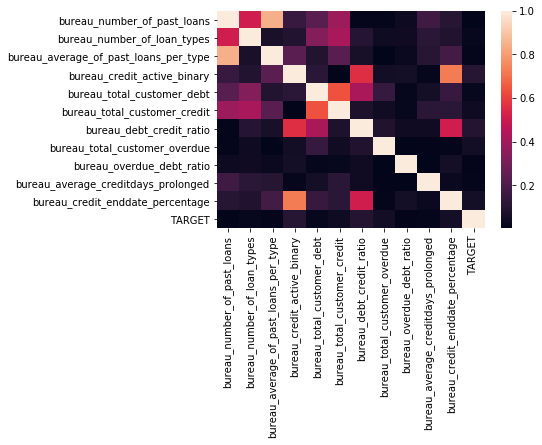

In [89]:
sns.heatmap(bureau_eng_corr, 
            xticklabels=bureau_eng_corr.columns,
            yticklabels=bureau_eng_corr.columns)

# Solution 4
## Hand Crafted Features

In [61]:
# group = bureau[bureau['bureau_credit_enddate_binary'] == 1].groupby(
#     by=['SK_ID_CURR']).apply(
#     lambda x: x.sort_values(['DAYS_CREDIT_ENDDATE'], ascending=True)).reset_index(drop=True)
# group['bureau_days_enddate_diff'] = group.groupby(by=['SK_ID_CURR'])['DAYS_CREDIT_ENDDATE'].diff()
# group['bureau_days_enddate_diff'] = group['bureau_days_enddate_diff'].fillna(0).astype('uint32')

# bureau = bureau.merge(group[['bureau_days_enddate_diff', 'SK_ID_BUREAU']], on=['SK_ID_BUREAU'], how='left')
# bureau['bureau_average_enddate_future'] = bureau.groupby(
#     by=['SK_ID_CURR'])['bureau_days_enddate_diff'].agg('mean').reset_index()['bureau_days_enddate_diff']

# bureau['bureau_days_credit_diff'] = bureau.groupby(
#     by=['SK_ID_CURR']).apply(
#     lambda x: x.sort_values(['DAYS_CREDIT'], ascending=False)).reset_index(drop=True)['DAYS_CREDIT']
# bureau['bureau_days_credit_diff'] *= -1
# bureau['bureau_days_credit_diff'] = bureau.groupby(by=['SK_ID_CURR'])['bureau_days_credit_diff'].diff()
# bureau['bureau_days_credit_diff'] = bureau['bureau_days_credit_diff'].fillna(0)

0         906.0
1        1183.0
2         109.0
3        3401.0
4         928.0
5         363.0
6         477.0
7         694.0
8         742.0
9        1568.0
10       1031.0
11        479.0
12        783.0
13        341.0
14        453.0
15        677.0
16         65.0
17        931.0
18        201.0
19        756.0
20        961.0
21        566.0
22        572.0
23        845.0
24      27236.0
25      30887.0
27        785.0
28       1272.0
29        130.0
30         19.0
         ...   
3515      630.0
3516     1714.0
3517      172.0
3518      376.0
3519      728.0
3520      758.0
3521      972.0
3524       14.0
3525      837.0
3526     1022.0
3527      269.0
3528     1297.0
3529      828.0
3530      543.0
3531     9957.0
3532     1539.0
3533    27544.0
3534    27544.0
3535     1065.0
3536     1310.0
3537      161.0
3538      265.0
3539     1118.0
3540     1576.0
3541      701.0
3542      828.0
3543      859.0
3544      886.0
3545      918.0
3546     1262.0
Name: DAYS_CREDIT_ENDDAT